<a href="https://colab.research.google.com/github/HyeonggiHwang/Googlemap-Review-Sentiment-Analysis-Using-Kobert/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리


In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 40.5 MB/s 
     |████████████████████████████████| 465 kB 13.9 MB/s 


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-wv0ipdd3/kobert-tokenizer_942cb86218064531854a349a278460c8
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-wv0ipdd3/kobert-tokenizer_942cb86218064531854a349a278460c8
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4648 sha256=ddab3b7d1cb26755bc3b65cbfb09d3b1bfd41a92bd1cb86c1aaf4012874bd6a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-o3ickiuu/wheels/f7/cb/29/1a737fe71e5108dc30b04ea4a990f78ed271fa537aaf3fce7c
Successfully built kobert-tokenizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-zzo_agne
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-bui

In [4]:
#!pip install torch==1.12.1

In [5]:
"""
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.6
!pip install transformers==4.8.1
"""


'\n!pip install mxnet\n!pip install gluonnlp pandas tqdm\n!pip install sentencepiece==0.1.6\n!pip install transformers==4.8.1\n'

# 1. 전처리

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/google_review.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/google_review2.csv')

In [9]:
df1.head()

,attraction,name,stars,review,duration
0,산굼부리,박다원,NaN,별표 5개,10년만에 다시 찾은 산굼부리인데요.. 완전 좋아졌더라구요. 걷는길도 더 편하게 되...
1,산굼부리,MJ C,NaN,별표 5개,"제주도 내륙, 조천읍에 위치한 오름이다. 성산일출봉과 더불어 예전부터 유명했던 오름..."
2,산굼부리,이용한,NaN,별표 5개,제주의 명소라 해도 손색없음. 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기...
3,산굼부리,그러니까,NaN,별표 3개,"산굼부리.. 입장료 6천원 2명에서 12,000을 사용했습니다. 미리 말하자면 이정..."
4,산굼부리,BK,NaN,별표 4개,제주의 대표적 오름\n어떤 계절이든 멋진 경관 감상가능\n바람이 항상 많이 불어 1...


In [10]:
df2.head()

,attraction,name,stars,review,duration
0,새별오름,jong kuk Kim,NaN,별표 5개,"해발 519.3m, 아마도 이 지대가 높아 그런것 같다. 절대 새별오름을 바라보명 ..."
1,새별오름,CHA CHA RYU,NaN,별표 5개,해질 무렵 방문했습니다.\n10월 하순 너무 너무 좋았습니다.\n경사는 가파르지만 ...
2,새별오름,JUDO JE,NaN,별표 5개,30~40분 걸으면서 경치보기 딱좋은곳입니다 힘들지도 않고 네려오면 주차장 주변에 ...
3,새별오름,Khan Kim (Dreamerian),NaN,별표 5개,제주 중문단지에서 공항으로 향하는 방향에서 들리기 좋은 새별오름.\n딱 2가지만 강...
4,새별오름,나야나,NaN,별표 5개,새뱔오름 오를때 왼쪽으로 올라가게되는데\n힘드신분은 오른쪽으로 가세요. 좀더 수월해...


In [11]:
df1.shape, df2.shape

((11427, 5), (9027, 5))

In [12]:
df = pd.concat([df1, df2])
df.shape

(20454, 5)

In [13]:
df.rename(columns = {'stars':'duration','review':'rating', 'duration':'review'},inplace=True)
df.head()

,attraction,name,duration,rating,review
0,산굼부리,박다원,NaN,별표 5개,10년만에 다시 찾은 산굼부리인데요.. 완전 좋아졌더라구요. 걷는길도 더 편하게 되...
1,산굼부리,MJ C,NaN,별표 5개,"제주도 내륙, 조천읍에 위치한 오름이다. 성산일출봉과 더불어 예전부터 유명했던 오름..."
2,산굼부리,이용한,NaN,별표 5개,제주의 명소라 해도 손색없음. 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기...
3,산굼부리,그러니까,NaN,별표 3개,"산굼부리.. 입장료 6천원 2명에서 12,000을 사용했습니다. 미리 말하자면 이정..."
4,산굼부리,BK,NaN,별표 4개,제주의 대표적 오름\n어떤 계절이든 멋진 경관 감상가능\n바람이 항상 많이 불어 1...


In [14]:
df = df.drop(columns=['duration', 'name'])
df.head()

,attraction,rating,review
0,산굼부리,별표 5개,10년만에 다시 찾은 산굼부리인데요.. 완전 좋아졌더라구요. 걷는길도 더 편하게 되...
1,산굼부리,별표 5개,"제주도 내륙, 조천읍에 위치한 오름이다. 성산일출봉과 더불어 예전부터 유명했던 오름..."
2,산굼부리,별표 5개,제주의 명소라 해도 손색없음. 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기...
3,산굼부리,별표 3개,"산굼부리.. 입장료 6천원 2명에서 12,000을 사용했습니다. 미리 말하자면 이정..."
4,산굼부리,별표 4개,제주의 대표적 오름\n어떤 계절이든 멋진 경관 감상가능\n바람이 항상 많이 불어 1...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20454 entries, 0 to 9026
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   attraction  20454 non-null  object
 1   rating      20454 non-null  object
 2   review      17566 non-null  object
dtypes: object(3)
memory usage: 639.2+ KB


In [16]:
df['rating'] = df['rating'].str.replace('[^0-9]', '')
df.head()

<ipython-input-16-216b2fa1ab53>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['rating'] = df['rating'].str.replace('[^0-9]', '')


,attraction,rating,review
0,산굼부리,5,10년만에 다시 찾은 산굼부리인데요.. 완전 좋아졌더라구요. 걷는길도 더 편하게 되...
1,산굼부리,5,"제주도 내륙, 조천읍에 위치한 오름이다. 성산일출봉과 더불어 예전부터 유명했던 오름..."
2,산굼부리,5,제주의 명소라 해도 손색없음. 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기...
3,산굼부리,3,"산굼부리.. 입장료 6천원 2명에서 12,000을 사용했습니다. 미리 말하자면 이정..."
4,산굼부리,4,제주의 대표적 오름\n어떤 계절이든 멋진 경관 감상가능\n바람이 항상 많이 불어 1...


In [17]:
df.isnull().sum()

attraction       0
rating           0
review        2888
dtype: int64

In [18]:
df.dropna(inplace=True)
df.isnull().sum()

attraction    0
rating        0
review        0
dtype: int64

In [19]:
df.shape

(17566, 3)

In [20]:
df['review'].nunique(), df['rating'].nunique()

(15717, 5)

In [21]:
df.drop_duplicates(subset=['review'], inplace=True)
df.shape

(15717, 3)

In [22]:
df['rating'].value_counts()

5    9031
4    4500
3    1480
1     379
2     327
Name: rating, dtype: int64

In [23]:
df.review

0       10년만에 다시 찾은 산굼부리인데요.. 완전 좋아졌더라구요. 걷는길도 더 편하게 되...
1       제주도 내륙, 조천읍에 위치한 오름이다. 성산일출봉과 더불어 예전부터 유명했던 오름...
2       제주의 명소라 해도 손색없음. 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기...
3       산굼부리.. 입장료 6천원 2명에서 12,000을 사용했습니다. 미리 말하자면 이정...
4       제주의 대표적 오름\n어떤 계절이든 멋진 경관 감상가능\n바람이 항상 많이 불어 1...
                              ...                        
8952                                              그냥 지나간곳
8953                                                  맛나요
8954                                            낚시 :) 조으다
8955                                                 멀미질색
8956    Beautiful place, but very hard to get to via p...
Name: review, Length: 15717, dtype: object

In [24]:
df['review'] = df['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
df['review'] = df['review'].str.replace('^ +', "", regex=True)
df['review'].replace('', np.nan, inplace=True)
df.isnull().sum()

attraction     0
rating         0
review        68
dtype: int64

In [25]:
df.loc[df.review.isnull()][:5]

,attraction,rating,review
206,신창풍차해안도로,5,NaN
890,제주항연안여객터미널,4,NaN
893,제주항연안여객터미널,4,NaN
1579,화조원,5,NaN
1580,화조원,5,NaN


In [26]:
df = df.dropna(how = 'any')
df.isnull().sum()

attraction    0
rating        0
review        0
dtype: int64

In [27]:
df.shape

(15649, 3)

In [28]:
df.head(10)

,attraction,rating,review
0,산굼부리,5,년만에 다시 찾은 산굼부리인데요 완전 좋아졌더라구요 걷는길도 더 편하게 되있고 전망...
1,산굼부리,5,제주도 내륙 조천읍에 위치한 오름이다 성산일출봉과 더불어 예전부터 유명했던 오름 중...
2,산굼부리,5,제주의 명소라 해도 손색없음 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기에...
3,산굼부리,3,산굼부리 입장료 천원 명에서 을 사용했습니다 미리 말하자면 이정도의 값어치는 아니라...
4,산굼부리,4,제주의 대표적 오름어떤 계절이든 멋진 경관 감상가능바람이 항상 많이 불어 월은 좀 추운편
5,산굼부리,5,가을 제주여행시 추천하는 여행지입니다유료로 입장료를 받고 있으며
6,산굼부리,4,너무유명한오름한바퀴돌면서힐링할수있는장소가을에는더좋겠지만봄여름에도사람이없어더한적하게즐...
7,산굼부리,5,세번째 오지만 올 때마다 다른 모습을 보여준다까도 까도 계속 다른 매력이 보여지는 ...
8,산굼부리,4,천년기념물로 지정된 산굼부리는 세계적으로도 희귀한 마르형 분화구로 오래전에는 분화구...
9,산굼부리,5,한라산분화구인 백록담보다 더 깊고 더 넓은 신비의 화구 산굼부리입장료 천원


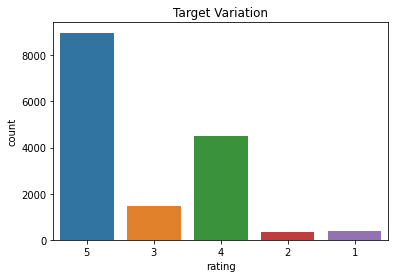

In [29]:
sns.countplot(x = 'rating', data=df)
plt.title("Target Variation")
plt.show()

In [30]:
#라벨링
pd.set_option('mode.chained_assignment',  None)
mapping = {'5': 2, '4':2, '3':1, '2':0, '1':0}
df['label'] = df.rating.map(mapping)
df.head()

,attraction,rating,review,label
0,산굼부리,5,년만에 다시 찾은 산굼부리인데요 완전 좋아졌더라구요 걷는길도 더 편하게 되있고 전망...,2
1,산굼부리,5,제주도 내륙 조천읍에 위치한 오름이다 성산일출봉과 더불어 예전부터 유명했던 오름 중...,2
2,산굼부리,5,제주의 명소라 해도 손색없음 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기에...,2
3,산굼부리,3,산굼부리 입장료 천원 명에서 을 사용했습니다 미리 말하자면 이정도의 값어치는 아니라...,1
4,산굼부리,4,제주의 대표적 오름어떤 계절이든 멋진 경관 감상가능바람이 항상 많이 불어 월은 좀 추운편,2


In [31]:
df_review = df.drop(columns=['attraction', 'rating']).reset_index(drop=True)
df_review.head()

,review,label
0,년만에 다시 찾은 산굼부리인데요 완전 좋아졌더라구요 걷는길도 더 편하게 되있고 전망...,2
1,제주도 내륙 조천읍에 위치한 오름이다 성산일출봉과 더불어 예전부터 유명했던 오름 중...,2
2,제주의 명소라 해도 손색없음 일반 분지와는 다른 오름과는 완만한 경사이기에 오르기에...,2
3,산굼부리 입장료 천원 명에서 을 사용했습니다 미리 말하자면 이정도의 값어치는 아니라...,1
4,제주의 대표적 오름어떤 계절이든 멋진 경관 감상가능바람이 항상 많이 불어 월은 좀 추운편,2


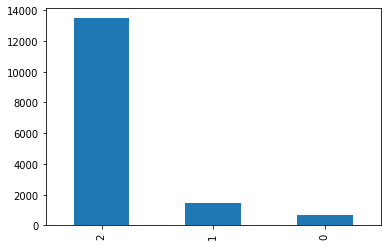

In [32]:
df_review.label.value_counts().plot(kind='bar')

In [33]:
df_review.label.value_counts()

2    13474
1     1472
0      703
Name: label, dtype: int64

In [34]:
data_list = []
for q, label in zip(df_review['review'], df_review['label'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [35]:
#train, test data split
train, test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=42)
print(len(train))
print(len(test))

12519
3130


# 2. 토큰화

In [36]:
from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert import get_tokenizer
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)


/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [37]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [38]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [39]:
data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

In [40]:
data_train[0]

(array([   2, 5192, 7427, 7101, 5541, 7318, 2584, 2149, 6855, 7609, 7354,
        5772, 4154, 5760, 5129, 2514, 6629, 5561, 5965,  736, 5451, 7119,
        5943,  493, 5139, 7096, 5736, 6797, 6553,  517, 6201, 5859, 1204,
         517, 6755, 7350, 6213, 6113, 5405, 7089, 5795, 7110, 1119, 7848,
        5859, 1611, 5495, 6168, 5330, 5765, 7828, 5377,  830, 5839, 5495,
        6999,    3,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(57, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 2)

In [41]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [42]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [43]:
device = torch.device("cuda:0")

In [44]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [45]:
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

In [46]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-46-480b6a139979>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.9470851421356201 train acc 0.5625
epoch 1 train acc 0.8399071166928309


<ipython-input-46-480b6a139979>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 1 test acc 0.8623658515130189


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6026825904846191 train acc 0.78125
epoch 2 train acc 0.8584306318681318


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 2 test acc 0.8617280964109781


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.4534459114074707 train acc 0.78125
epoch 3 train acc 0.8729334281789639


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 3 test acc 0.8706566678395495


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.49612823128700256 train acc 0.828125
epoch 4 train acc 0.8867248822605966


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 4 test acc 0.8633224841660802


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.44662418961524963 train acc 0.8125
epoch 5 train acc 0.9083288363422293


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 5 test acc 0.8511061752287121


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.3617493510246277 train acc 0.84375
epoch 6 train acc 0.923845499738357


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 6 test acc 0.8498636523574946


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.26183927059173584 train acc 0.9375
epoch 7 train acc 0.9458991529304029


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 7 test acc 0.8492588845883181


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.19260697066783905 train acc 0.921875
epoch 8 train acc 0.9582045558608059


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 8 test acc 0.8543609254046446


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.15528658032417297 train acc 0.9375
epoch 9 train acc 0.9667059131344846


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 9 test acc 0.856274190710767


  0%|          | 0/196 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.09654950350522995 train acc 0.984375
epoch 10 train acc 0.970133846807954


  0%|          | 0/49 [00:00<?, ?it/s]

epoch 10 test acc 0.8556364356087263


In [47]:
test_acc/(batch_id+1)

0.8556364356087263

# 3. Predict

In [90]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

def testModel(model, seq):
    sentiment = ['부정','중립','긍정']
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    model.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()
    print("이 관광지에 대해 "+sentiment[idx]+'적일 확률은 약', "{:.2f}%".format(softmax(result,idx)), '입니다.', end="\n\n")

In [91]:
import warnings
warnings.filterwarnings('ignore')

review_text1 = '넓게 펼쳐진 들판 억새 너무 이뻐요'
review_text2 = '무난한 것 같아요'
review_text3 = '관리자분이 욕을 하시더라구요. 본인 퇴근시간에 1분이라도 늦어지면 욕하는게 아주 불쾌했습니다.'
review_text4 = '별로,, 돈아까움'

print(review_text1)
testModel(model, review_text1)
print(review_text2)
testModel(model, review_text2)
print(review_text3)
testModel(model, review_text3)
print(review_text4)
testModel(model, review_text4)

넓게 펼쳐진 들판 억새 너무 이뻐요
이 관광지에 대해 긍정적일 확률은 약 98.28% 입니다.

무난한 것 같아요
이 관광지에 대해 중립적일 확률은 약 93.61% 입니다.

관리자분이 욕을 하시더라구요. 본인 퇴근시간에 1분이라도 늦어지면 욕하는게 아주 불쾌했습니다.
이 관광지에 대해 부정적일 확률은 약 58.28% 입니다.

별로,, 돈아까움
이 관광지에 대해 부정적일 확률은 약 97.89% 입니다.



# 기타

In [50]:
# 불용어 설정
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [51]:
# 형태소 분석기 설정 okt = Okt()
# 토큰화
#X_train = []
#for sentence in tqdm(train_data['document']):
#    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
#    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
#    X_train.append(stopwords_removed_sentence)

In [52]:
#X_train[:3]

In [53]:
#테스트데이터에도 똑같이 적용
"""
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)
"""

"\nX_test = []\nfor sentence in tqdm(test_data['document']):\n    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화\n    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거\n    X_test.append(stopwords_removed_sentence)\n"

In [54]:
#정수인코딩
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(X_train)

In [55]:
# print(tokenizer.word_index)

In [56]:
"""

등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
"""

'\n\n등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.\n\nthreshold = 3\ntotal_cnt = len(tokenizer.word_index) # 단어의 수\nrare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트\ntotal_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합\nrare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합\n\n# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.\nfor key, value in tokenizer.word_counts.items():\n    total_freq = total_freq + value\n\n    # 단어의 등장 빈도수가 threshold보다 작으면\n    if(value < threshold):\n        rare_cnt = rare_cnt + 1\n        rare_freq = rare_freq + value\n\nprint(\'단어 집합(vocabulary)의 크기 :\',total_cnt)\nprint(\'등장 빈도가 %s번 이하인 희귀 단어의 수: %s\'%(threshold - 1, rare_cnt))\nprint("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)\nprint("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)\n'

In [57]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
#vocab_size = total_cnt - rare_cnt + 1
#print('단어 집합의 크기 :',vocab_size)

In [58]:
"""
케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
"""

'\n케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.\n\ntokenizer = Tokenizer(vocab_size) \ntokenizer.fit_on_texts(X_train)\nX_train = tokenizer.texts_to_sequences(X_train)\nX_test = tokenizer.texts_to_sequences(X_test)\n'

In [59]:
# print(X_train[:3])

In [60]:
"""
train_data에서 y_train과 y_test를 별도로 저장해줍니다 .
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
"""

"\ntrain_data에서 y_train과 y_test를 별도로 저장해줍니다 .\ny_train = np.array(train_data['label'])\ny_test = np.array(test_data['label'])\n"

In [61]:
# 빈 샘플(empty samples) 제거

